# t-SNE visualization of Problem 2

## Load Cats and Dogs Dataset and Model from Problem 2

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
  
!wget https://github.com/Stnslv/ML-Homeworks/blob/master/HW3/VGG19_P2_best.h5?raw=true \
  -O P2_model.h5

--2019-04-18 15:40:50--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   103MB/s    in 0.6s    

2019-04-18 15:40:51 (103 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

--2019-04-18 15:40:51--  https://github.com/Stnslv/ML-Homeworks/blob/master/HW3/VGG19_P2_best.h5?raw=true
Resolving github.com (github.com)... 192.30.255.112, 192.30.255.113
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Stnslv/ML-Homeworks/raw/master/HW3/VGG19_P2_best.h5 [following]
--2019-0

## Import Statements

In [2]:
import os
import zipfile
from google.colab import files
from keras.models import load_model

from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

from sklearn.manifold import TSNE

Using TensorFlow backend.


## Load Cats/Dogs Validation Set

In [0]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [4]:
# Use batches of powers of two to take advantage of GPU.
batches = 32
val_steps = int(1000/batches)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 1000 images belonging to 2 classes.


In [5]:
# Load the model obtained from Problem 2.
model = load_model('P2_model.h5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 21,073,217
Trainable para

## Get last activation layer

In [6]:
layer = model.get_layer('dense_1')
layer_output = layer.output

activation_model = models.Model(input=model.input, outputs=[layer_output])
activations = activation_model.predict_generator(validation_generator, steps=val_steps)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("vg...)`
  after removing the cwd from sys.path.


In [7]:
activations.shape

(992, 128)

In [8]:
activations[0]

array([2.65166903e+00, 0.00000000e+00, 3.80679742e-02, 0.00000000e+00,
       6.33895844e-02, 1.53731510e-01, 7.56125446e-05, 2.37422809e-02,
       0.00000000e+00, 1.99709758e-01, 0.00000000e+00, 0.00000000e+00,
       3.47567722e-04, 1.02482669e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.13262871e-01, 0.00000000e+00, 3.37438631e+00,
       3.27447563e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.49799171e-02, 0.00000000e+00, 4.02510214e+00,
       8.56865883e-01, 5.04608750e-02, 0.00000000e+00, 6.88768625e-01,
       0.00000000e+00, 7.90312141e-02, 6.10922158e-01, 0.00000000e+00,
       9.91655812e-02, 2.07088804e+00, 4.15907830e-01, 5.20509899e-01,
       1.74107432e+00, 1.39005971e+00, 2.17426610e+00, 2.58915186e-01,
       0.00000000e+00, 6.50740957e+00, 0.00000000e+00, 1.20111994e-01,
       0.00000000e+00, 1.04054727e-03, 0.00000000e+00, 6.05825233e+00,
       0.00000000e+00, 5.01434803e-01, 0.00000000e+00, 0.00000000e+00,
      

## Visualization of the feature vectors

In [0]:
class_names = ['Cat', 'Dog']

def data_scatter(vecs, labels):
    # Choose a color palette with seaborn.
    num_classes = 2
    palette = np.array(sns.color_palette("husl", num_classes))

    # Create a scatter plot of the activations with respect to labels.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    for idx in range(num_classes):
        # Place label at median position of vectors with corresponding label.
        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        # plot class index black with white contour.
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])

## t-SNE 

In [10]:
time_start = time.time()

fashion_tsne = TSNE(random_state=42).fit_transform(activations)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

t-SNE done! Time elapsed: 5.581480026245117 seconds


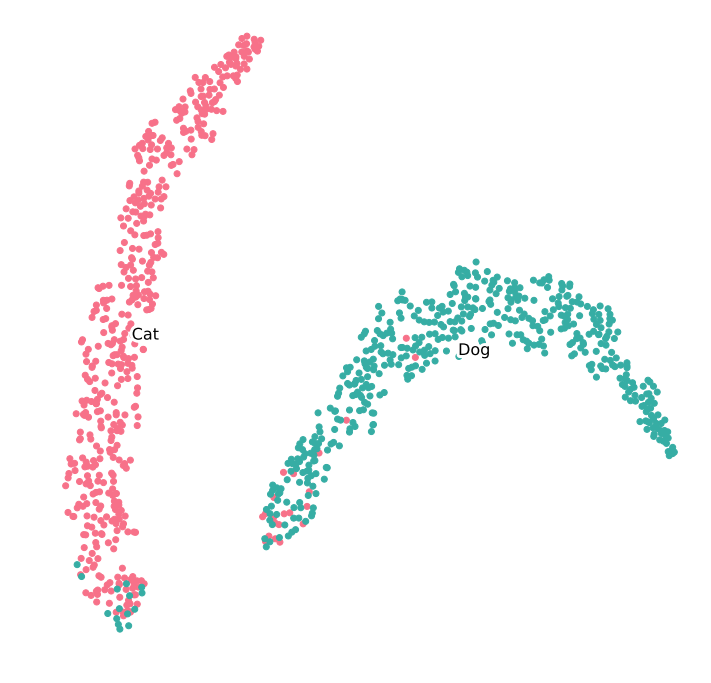

In [11]:
# Visualize t-SNE output
labels = validation_generator.classes
labels = labels[:val_steps*batches]
data_scatter(fashion_tsne, labels)
